In [33]:
import numpy as np
import pandas as pd
import os

class ModelData:
    def __init__(self):
        self.name = None
        self.seed = None
        self.run = None
        self.gem = None
        self.gem_id = None
        self.pos = None
        self.people = None
        self.phases = None
        self.status = None
        self.timestep = None

        self.exposed = None
        self.infected = None
        self.recovered = None
        self.hospital = None

# Load data
def load_data(seed, run, intervention):
    path = os.getcwd() + '/Data/Model_V1/Data/'

    data = ModelData()
    data.name = intervention
    data.seed = seed
    data.run = run
    
    data.gem = pd.read_pickle(path + 'Gemeenten.pkl')
    data.gem_id = pd.read_pickle(path +'GemeentenID.pkl')
    data.pos = np.load(path + 'Positions.npy')

    try:
        path = os.getcwd() + '/Data/Model_V1/Data/High/Seed_' + str(seed) + '/'

        data.people = pd.read_pickle(path + 'PeopleDF.pkl')

        data.phases = pd.read_pickle(path + 'Runs_' + intervention + '/Phases_' + str(run) + '.pkl')
        data.status = np.load(path + 'Runs_' + intervention + '/Status_' + str(run) + '.npz')
        data.timestep = np.loadtxt(path + 'Runs_' + intervention + '/Timestep_' + str(run))
    except:
        print("Error loading data ({}, {}, {})".format(intervention, seed, run))
        return

    return data

In [34]:
seeds = [2]
runs = [4]
interventions = ['ref', 'behavior', 'working', 'school']

data_points = []
for seed in seeds:
    for run in runs:
        for intervention in interventions:
            data_points.append(load_data(seed, run, intervention))

data_points = list(filter(None, data_points))
print('Succesfully loaded ' + str(len(data_points)) + ' data points')

Error loading data (behavior, 2, 4)
Error loading data (working, 2, 4)
Error loading data (school, 2, 4)
Succesfully loaded 1 data points


In [35]:
# Print info for a specific datapoint
data = data_points[0]
print('name: ', data.name)
print('gem: ', data.gem.shape)
print('gem_id: ', data.gem_id.shape)
print('pos: ',data.pos.shape)
print('people: ',data.people.shape)
print(data.status.files)

# timesteps: n_days * 24
print('timesteps: ', data.status['indptr'].shape)
#indices of all people that are infected at timestep t=1000
#print('status: ', data.status['indices'][data.status['indptr'][1000] : data.status['indptr'][1001]])
print(data.people['Group'][0])

print(np.argmax(data.phases[0]==2))
print(np.argmax(data.phases[0]==3))
print(np.argmax(data.phases[0]==4))

name:  ref
gem:  (380, 1)
gem_id:  (380, 1)
pos:  (7, 24, 170721)
people:  (170721, 382)
['indices', 'indptr', 'format', 'shape', 'data']
timesteps:  (2881,)
a) Pre-school children
368
632
1808


In [36]:
# map containing hospitalisation values per demographic group
p_hos_map = {
    'a) Pre-school children':       0,
    'b) Primary school children':   0,
    'c) Secondary school children': 0.0018,
    'd) Students':                  0.0006,
    'e) Non-studying adolescents':  0.0006,
    'f) Middle-age working':        0.0081,
    'g) Middle-age unemployed':     0.0081,
    'h) Higher-age working':        0.0276,
    'i) Higher-age unemployed':     0.0276,
    'j) Elderly':                   0.0494,
    'k) Eldest':                    0.0641
}

# Compute model data per timestep
for data in data_points:
    timesteps = data.status['indptr'].shape[0] -1
    raw_data = data.status['data']
    indptr = data.status['indptr']
    indices = data.status['indices']

    data.hospital = np.zeros(timesteps)
    data.exposed = np.zeros(timesteps)
    data.infected = np.zeros(timesteps)
    data.recovered = np.zeros(timesteps)

    #prev_infected = set()
    for t in range(0, timesteps):
        timestamp_row = raw_data[indptr[t] : indptr[t + 1]]
        infected_mask = timestamp_row == 2
        infected_row = indices[indptr[t] : indptr[t + 1]][infected_mask]
        #print(len(infected_row))

        # get new infected cases a.k.a people that are not in prev_infected
        #new_infected = set(infected_row).difference(prev_infected)
        #prev_infected = infected_row

        # Compute which agents will be hospitalised (based on p_hos), and after how long (based on weibull distribution mean 14, scale 10)
        p_hos = [p_hos_map[data.people['Group'][agent]] for agent in infected_row]
        mask_hos = np.random.rand(len(infected_row)) < p_hos
        time_lag = 24 * np.random.weibull(14/10, size=len(infected_row)) * 10
        hos_time = time_lag[mask_hos].astype(int)
        
        # Store the hospitalisation on correct timestep
        for ht in hos_time:
            time = t + ht
            if time < timesteps:
                data.hospital[time] += 1
        

        # assign data to object
        data.exposed[t] = np.count_nonzero(timestamp_row == 1)
        data.infected[t] = np.count_nonzero(timestamp_row == 2)
        data.recovered[t] = np.count_nonzero(timestamp_row == 3)

# Check some general info
# print(data_points[0].infected.size)
# print(np.argmin(data_points[0].infected))
        

In [37]:
# weibull testing
d = data_points[0]

mean = 14
scale = 10
samples = np.random.weibull(mean/scale, 100) * scale
print(np.average(samples))



8.71709498287526


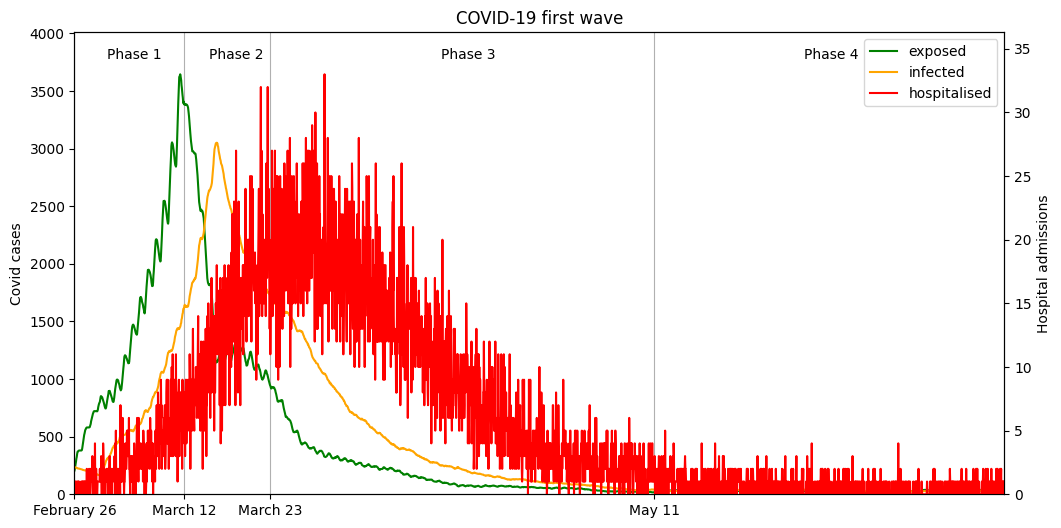

In [42]:
import matplotlib.pyplot as plt

# Recreates figure 2(a) of the paper

fig, ax1 = plt.subplots(figsize=(12, 6))
ax2 = ax1.twinx()

plt.title('COVID-19 first wave')
plt.xlabel('time (h)')

ax1.set_ylabel('Covid cases')
ax2.set_ylabel('Hospital admissions')

#Get starts of phases
phase2 = np.argmax(data.phases[0]==2)
phase3 = np.argmax(data.phases[0]==3)
phase4 = np.argmax(data.phases[0]==4) # might be 0 if model ran for too little days, dont include in 'phases' list in that case
phase1 = phase2 - 14 * 24 # feb 27th is 14 days before march 12th

phases = [phase1, phase2, phase3, phase4]

x_max = len(data.hospital)
plt.xlim(phase1, x_max)
y1_max = np.max(data.exposed)
y2_max = np.max(data.hospital)
ax1.set_ylim([0, y1_max * 1.1])
ax2.set_ylim([0, y2_max * 1.1])

lines = []
time_range = np.arange(0, x_max)
for data in [data_points[0]]:
    ln1 = ax1.plot(time_range, data.exposed, label='exposed', color='green')
    ln2 = ax1.plot(time_range, data.infected, label='infected', color='orange')
    ln3 = ax2.plot(time_range, data.hospital, label='hospitalised', color='red')
    lines = lines + ln1 + ln2 + ln3

# Print phase labels on top of graph
phase_labels = ['Phase 1', 'Phase 2', 'Phase 3', 'Phase 4']
phase_label_pos = np.array([phase2 /2, (phase3+phase2) / 2, (phase4+phase3) / 2, (x_max+phase4) / 2]) / x_max
for label, pos in zip(phase_labels, phase_label_pos):
    ax1.text(pos, 0.95, label, transform=ax1.transAxes,
         ha='center', va='center', fontsize=10)

# Compute phase date
march12 = pd.to_datetime('2022-03-12')
date_p1 = march12 + pd.DateOffset(hours= -int(phase2-phase1))
date_p3 = march12 + pd.DateOffset(hours=  int(phase3-phase2))
date_p4 = march12 + pd.DateOffset(hours=  int(phase4-phase2))

# Print specific date labels on x-axis
ax1.grid(axis='x')
ax1.set_xticks(phases, map(lambda dt: dt.strftime('%B %d'), [date_p1, march12, date_p3, date_p4]))
ax1.legend(lines, [l.get_label() for l in lines])
plt.show()

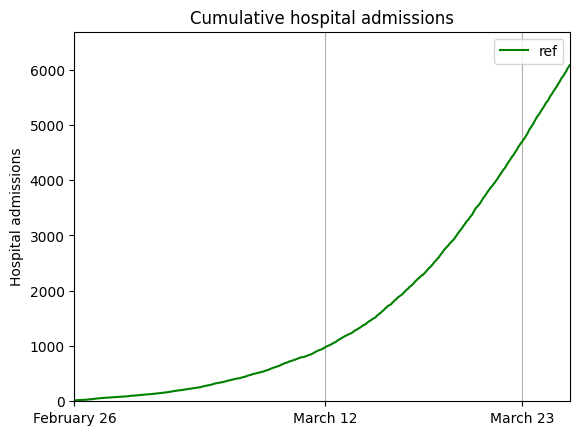

In [ ]:
# Recreates figure 3(a) of the paper

# For easy comparison to figure 3 of the paper.
color_map = {
    'ref': 'green',
    'school': 'orange',
    'behavior': 'blue',
    'working': 'red'
}

plt.title('Cumulative hospital admissions')

plt.ylabel('Hospital admissions')

x_max = len(data.hospital)
plt.xlim(phase1, x_max)
y_max = np.sum(data.hospital)
plt.ylim([0, y_max * 1.1])

for data in data_points:
    plt.plot(np.arange(0, len(data.hospital)), np.cumsum(data.hospital), label=data.name, color=color_map[data.name])

plt.grid(axis='x')
plt.xticks([phase1, phase2, phase3],
           labels= map(lambda dt: dt.strftime('%B %d'), [date_p1, march12, date_p3]))

plt.legend()
plt.show()

[55, 391, 655, 0]


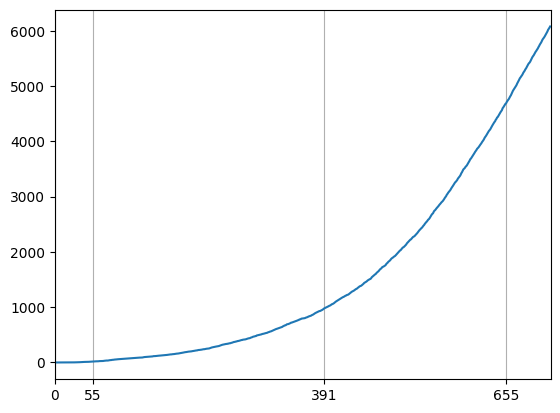

In [ ]:
import matplotlib.pyplot as plt

# Your data
x = np.arange(0, x_max)  # assuming data ranges from x=0 to x=100
y = np.cumsum(data.hospital)

# Plotting
plt.plot(x, y)

# Set the limit of the x-axis
plt.xlim(20, x_max)
plt.grid(axis='x')

# Define the ticks and labels
xticks = [phase1, phase2, phase3, phase4]
print(xticks)
xticklabels = [str(i) for i in xticks]

# Set the ticks and labels
plt.xticks(xticks, xticklabels)

# Show the plot
plt.show()